# Muultiwavelength HDF5 input
Added by Shooby: Oct 24th 2019, Last edited Nov 5th, 2020

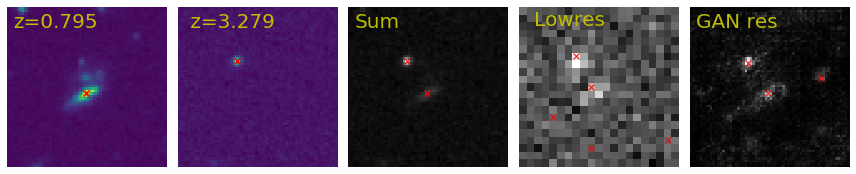

[2, 2, 2]


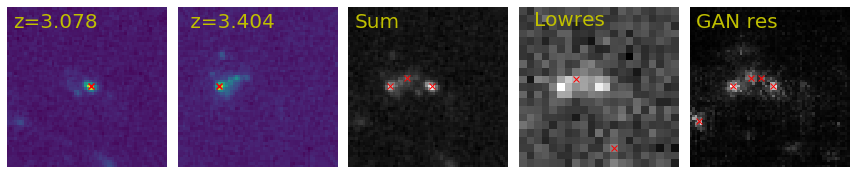

[2, 1, 2]


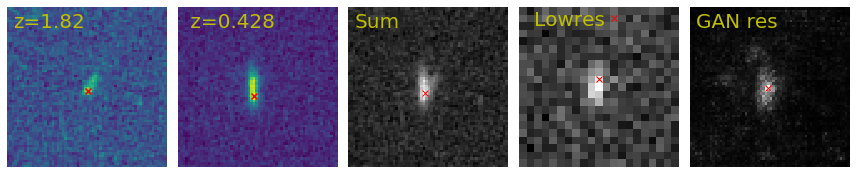

[1, 1, 1]


In [5]:
from galblend import *
%matplotlib inline

hi,i1,i2,lo,gan,psf_hires,psf_lores,data,nums = galblend(gals=2,sel_band=2,lim_hmag=25,plot_it=True)
print(nums)
hi,i1,i2,lo,gan,psf_hires,psf_lores,data,nums = galblend(gals=2,sel_band=2,lim_hmag=25,plot_it=True)
print(nums)
hi,i1,i2,lo,gan,psf_hires,psf_lores,data,nums = galblend(gals=2,sel_band=2,lim_hmag=25,plot_it=True)
print(nums)


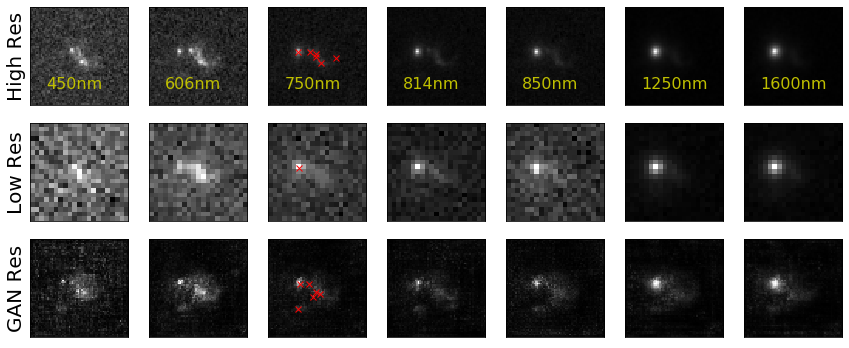

In [6]:
from galblend import *
imaggge,i1,i2,lo,gan,psf_hires,psf_lores,data,nums = galblend(gals=2,lim_hmag=24,plot_it=False)

###### detection in high res ##############
im = imaggge[2,:,:]
psf = pyfits.getdata('../psfs/psf_i.fits')
num = find_peaks(image=im-np.mean(im), kernel = psf,thresh=3*np.median(im))
x_hi,y_hi = [],[]
for boz in range(len(num)):
    if (1<num[boz][0]<64)&(1<num[boz][1]<64):
        x_hi.append(num[boz][1])
        y_hi.append(num[boz][0])

###### detection in low res ##############        
im = lo[2,:,:]
psf = pyfits.getdata('../psfs/PSF_subaru_i.fits')
num = find_peaks(image=im-np.mean(im), kernel = psf,thresh=3*np.median(im))
x_lo,y_lo = [],[]
for boz in range(len(num)):
    if (1<num[boz][0]<21)&(1<num[boz][1]<21):
        x_lo.append(num[boz][1])
        y_lo.append(num[boz][0])

###### detection in GAN res ##############

im = gan[2,:,:].data.numpy()
psf = pyfits.getdata('../psfs/psf_i.fits')
num = find_peaks(image=im-np.mean(im), kernel = psf,thresh=max(0.1,3*np.median(im)))
x_gan,y_gan = [],[]
for boz in range(len(num)):
    if (1<num[boz][0]<64)&(1<num[boz][1]<64):
        x_gan.append(num[boz][1])
        y_gan.append(num[boz][0])


plt.figure(figsize=(12,5))
filts = ['450nm','606nm','750nm','814nm','850nm','1250nm','1600nm']
for i in range(7):
        
    plt.subplot(3,7,i+1)
    plt.imshow(imaggge[i,:,:],origin='lower',cmap='gray')
    plt.text(10,10,filts[i],color='y',size=16)
    
    plt.xticks([])
    plt.yticks([])
    if i ==0:
        plt.ylabel('High Res',size=20)
    if i ==2:
        plt.plot(x_hi,y_hi,'rx')
    
    plt.subplot(3,7,7+i+1)
    plt.imshow(lo[i,:,:],origin='lower',cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if i ==0:
        plt.ylabel('Low Res',size=20) 
    if i ==2:
        plt.plot(x_lo,y_lo,'rx')
        
    plt.subplot(3,7,14+i+1)
    plt.imshow((gan[i,:,:]),origin='lower',cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if i ==0:
        plt.ylabel('GAN Res',size=20) 
    if i ==2:
        plt.plot(x_gan,y_gan,'rx')
plt.tight_layout()
plt.savefig('../plots/multi.png')

In [ ]:
import h5py
hf = h5py.File('Sample_train.hdf5', 'r')
hf.keys()

boz=np.random.randint(1,100)
mm = hf['train_img'][boz, ...]
plt.figure(figsize=(14,3))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(mm[i,:,:],origin='lower')
    plt.axis('off')
hf.close()

In [ ]:
#%rm 'Sample_train.hdf5'
import torchvision.transforms as transforms
from simgal import *
import h5py

sample_size = 4000

tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_shape = (sample_size, 7, 64, 64)

hdf5_file = h5py.File('Sample_train.hdf5', mode='w')
hdf5_file.create_dataset("train_img", train_shape, np.float32)
hdf5_file.create_dataset("train_labels", (sample_size,), np.float32)
hdf5_file["train_labels"][...] = np.zeros(sample_size)

for i in range(sample_size):
    # print how many images are saved every 1000 images
    im = simgal(gals=np.random.randint(1,3),lim_hmag=25,plot_it=False)
    if i % 500 == 0 and i > 1:
        print ('Train data: {}/{}'.format(i, sample_size))
    pashe = np.zeros((7,64,64))
    for chi in range(7):
        s = ndimage.rotate(im[chi,:,:],0,mode='nearest',reshape=False)
        da = np.arcsinh(s)
        pash = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        pashe[chi,:,:] = tfms(pash)
    # save the image and calculate the mean so far
    hdf5_file["train_img"][i, ...] = pashe

hdf5_file.close()

In [ ]:
plt.imshow(pashe[6,:,:])

In [ ]:
gs = pyfits.getdata('/Users/shemmati/Dropbox/WFIRST_WPS/CANDELS_fits/gds.fits')
sel = (gs['zbest']>0.01)&(gs['zbest']<4.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<25.)&(gs['ISOAREA_IMAGE_F160W']>=40)&(gs['DECdeg']>-27.87)

sample_size = len(gs[sel])
image_size = 64
cut_size = 32
ra1,dec1,red1 = gs['RA_1'][sel],gs['DEC_1'][sel],gs['zbest'][sel]
mass1,sfr1 = gs['M_neb_med_lin'][sel], gs['SFR_13a_tau'][sel]
urest1,vrest1,jrest1 = gs['restUXbessel'][sel],gs['restVbessel'][sel],gs['restJpalomar'][sel]

# furthur cut on brightest galaxy being at the center of the cutout
redshift,ra,dec,mass,sfr,urest,vrest,jrest = [],[],[],[],[],[],[],[]
for i in range(sample_size):
    dat = cut(ra1[i],dec1[i],cut_size,imdir+'goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    if (brightest_center(dat)):
        redshift.append(red1[i])
        ra.append(ra1[i])
        dec.append(dec1[i])
        mass.append(mass1[i])
        sfr.append(sfr1[i])
        urest.append(urest1[i])
        vrest.append(vrest1[i])
        jrest.append(jrest1[i])

sample_size = len(redshift)
print (sample_size)

In [ ]:
gs = pyfits.getdata('/Users/shemmati/Dropbox/WFIRST_WPS/CANDELS_fits/gds.fits')
sel = (gs['zbest']>0.01)&(gs['zbest']<2.0)&(gs['CLASS_STAR']<0.9)&(gs['Hmag']<25.)&(gs['ISOAREA_IMAGE_F160W']>=25)&(gs['DECdeg']<-27.87)

sample_size = len(gs[sel])
image_size = 64
cut_size = 32
ra1,dec1,red1 = gs['RA_1'][sel],gs['DEC_1'][sel],gs['zbest'][sel]
mass1,sfr1 = gs['M_neb_med_lin'][sel], gs['SFR_13a_tau'][sel]
urest1,vrest1,jrest1 = gs['restUXbessel'][sel],gs['restVbessel'][sel],gs['restJpalomar'][sel]

# furthur cut on brightest galaxy being at the center of the cutout
redshift,ra,dec,mass,sfr,urest,vrest,jrest = [],[],[],[],[],[],[],[]
for i in range(sample_size):
    dat = cut(ra1[i],dec1[i],cut_size,imdir+'goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    if (brightest_center(dat)):
        redshift.append(red1[i])
        ra.append(ra1[i])
        dec.append(dec1[i])
        mass.append(mass1[i])
        sfr.append(sfr1[i])
        urest.append(urest1[i])
        vrest.append(vrest1[i])
        jrest.append(jrest1[i])

sample_size = len(redshift)
print (sample_size)

In [ ]:
#%rm 'Sample.hdf5'
import torchvision.transforms as transforms
tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

train_shape = (sample_size, 7, 64, 64)

hdf5_file = h5py.File('Sample_test.hdf5', mode='w')

hdf5_file.create_dataset("test_img", train_shape, np.float32)
hdf5_file.create_dataset("test_labels", (sample_size,), np.float32)
hdf5_file["test_labels"][...] = redshift

for i in range(sample_size):
    # print how many images are saved every 1000 images
    if i % 500 == 0 and i > 1:
        print ('Test data: {}/{}'.format(i, len(gs[sel])))

        
    data = np.zeros((7,64,64))
    pashe = np.zeros((7,64,64))
    
    data[0,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f435w_060mas_v1.5_drz.fits')
    data[1,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f606w_060mas_v1.5_drz.fits')
    data[2,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
    data[3,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f814w_060mas_v1.5_drz.fits')
    data[4,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f850l_060mas_v1.5_drz.fits')
    data[5,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f125w_060mas_v1.0_drz.fits')
    data[6,:,:] = cut(ra1[i],dec1[i],32,'/Users/shemmati/Desktop/GOODS/goodss_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')

    for chi in range(7):
        s = ndimage.rotate(data[chi,:,:],0,mode='nearest',reshape=False)
        da = np.arcsinh(s)
        pash = (255.0 / (da.max()+0.1) * (da - da.min())).astype(np.uint8)
        pashe[chi,:,:] = tfms(pash)

    # save the image and calculate the mean so far
    hdf5_file["test_img"][i, ...] = pashe

hdf5_file.close()

In [ ]:
import torch
from galaxy_hdf5loader import galaxydata

dataset = galaxydata('Sample_train.hdf5')
assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,shuffle=True, num_workers=int(0))

inputs, classes = next(iter(dataloader))  
real_cpu = inputs.to('cpu')
ajab = real_cpu.detach()
ajab = ajab.cpu()

In [ ]:
plt.figure(figsize=(14,3))
for i in range(7):
    plt.subplot(1,7,i+1) 
    plt.imshow(ajab[0,i,:,:],origin='lower')
    plt.axis('off')
